In [25]:
import os, sys 

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
import pickle as pkl
import lightgbm as lgb

print(sys.version)
for i in [pd, mpl, sns, sklearn, scipy, lgb]:
    print(i.__name__, i.__version__)

3.12.3 (main, May  7 2024, 08:28:12) [GCC 9.4.0]
pandas 2.2.2
matplotlib 3.8.4
seaborn 0.13.2
sklearn 1.4.2
scipy 1.13.0
lightgbm 4.3.0


In [23]:
from IPython.display import Image
def cache_fig(img_name, img_func, nrow, ncol, figsize, redraw=False):
    img_file_name = os.path.join(img_path, img_name + '.png')
    if not os.path.exists(img_file_name) or redraw:
        fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
        if nrow * ncol > 1:
            img_func(axes.ravel())
        else:
            img_func(axes)
        plt.tight_layout()
        plt.savefig(img_file_name)
        plt.show()
    else:
        display(Image(filename=img_file_name))

def cache_result(result_name, result_func):
    result_file_name = os.path.join(result_path, result_name + '.pkl')
    if not os.path.exists(result_file_name):
        result = result_func()
        with open(result_file_name, 'wb') as f:
            pkl.dump(result, f)
    else:
        with open(result_file_name, 'rb') as f:
            result = pkl.load(f)
    return result

In [21]:
data_path = 'data'
img_path = 'img'
result_path = 'result'
if not os.path.isdir(img_path):
    os.mkdir(img_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('org', data_path, 'flood.csv'),
        ('test', data_path, 'test.csv'),
        ('type', data_path, 'type.pkl'),
        ('train_pkl', data_path, 'train.pkl'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_pkl', data_path, 'test.pkl'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

# 데이터 불러오기 및 변수 종류 설정

In [5]:
df_var = pd.read_pickle(files['var_pkl'])
df_train = pd.read_pickle(files['train_pkl'])
df_org = pd.read_pickle(files['org_pkl'])
df_test = pd.read_pickle(files['test_pkl'])

In [6]:
target = 'FloodProbability'
X_all = df_var.loc[~df_var.index.isin(['id', target])].index.tolist()

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int8   
 1   TopographyDrainage               1117957 non-null  int8   
 2   RiverManagement                  1117957 non-null  int8   
 3   Deforestation                    1117957 non-null  int8   
 4   Urbanization                     1117957 non-null  int8   
 5   ClimateChange                    1117957 non-null  int8   
 6   DamsQuality                      1117957 non-null  int8   
 7   Siltation                        1117957 non-null  int8   
 8   AgriculturalPractices            1117957 non-null  int8   
 9   Encroachments                    1117957 non-null  int8   
 10  IneffectiveDisasterPreparedness  1117957 non-null  int8   
 11  DrainageSystems                  1117957 non-null  int8

In [8]:
df_train[X_all].describe()

,AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,DeterioratingInfrastructure,DrainageSystems,Encroachments,InadequatePlanning,IneffectiveDisasterPreparedness,Landslides,MonsoonIntensity,PoliticalFactors,PopulationScore,RiverManagement,Siltation,TopographyDrainage,Urbanization,Watersheds,WetlandLoss
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,4.942619e+00,4.934093e+00,4.953999e+00,4.955878e+00,4.942240e+00,4.925907e+00,4.946893e+00,4.949230e+00,4.940587e+00,4.945239e+00,4.931376e+00,4.921450e+00,4.939004e+00,4.927520e+00,4.955322e+00,4.927791e+00,4.926671e+00,4.942517e+00,4.929032e+00,4.950859e+00
std,2.068545e+00,2.057742e+00,2.088899e+00,2.083063e+00,2.051689e+00,2.064813e+00,2.072333e+00,2.083324e+00,2.081123e+00,2.078141e+00,2.078287e+00,2.056387e+00,2.090350e+00,2.074176e+00,2.072186e+00,2.065992e+00,2.093879e+00,2.083391e+00,2.082395e+00,2.068696e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00
50%,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
75%,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00
max,1.600000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.800000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.800000e+01,1.600000e+01,1.600000e+01,1.800000e+01,1.700000e+01,1.600000e+01,1.900000e+01


X_all 은 모두 int8 형식으로 구성되어 있습니다. 분포를 보아 수치형인지, 범주형인지 살펴 봅니다. 

X_all은 모두 비슷한 범위를 가지고 있습니다.

## 변수들의 분포

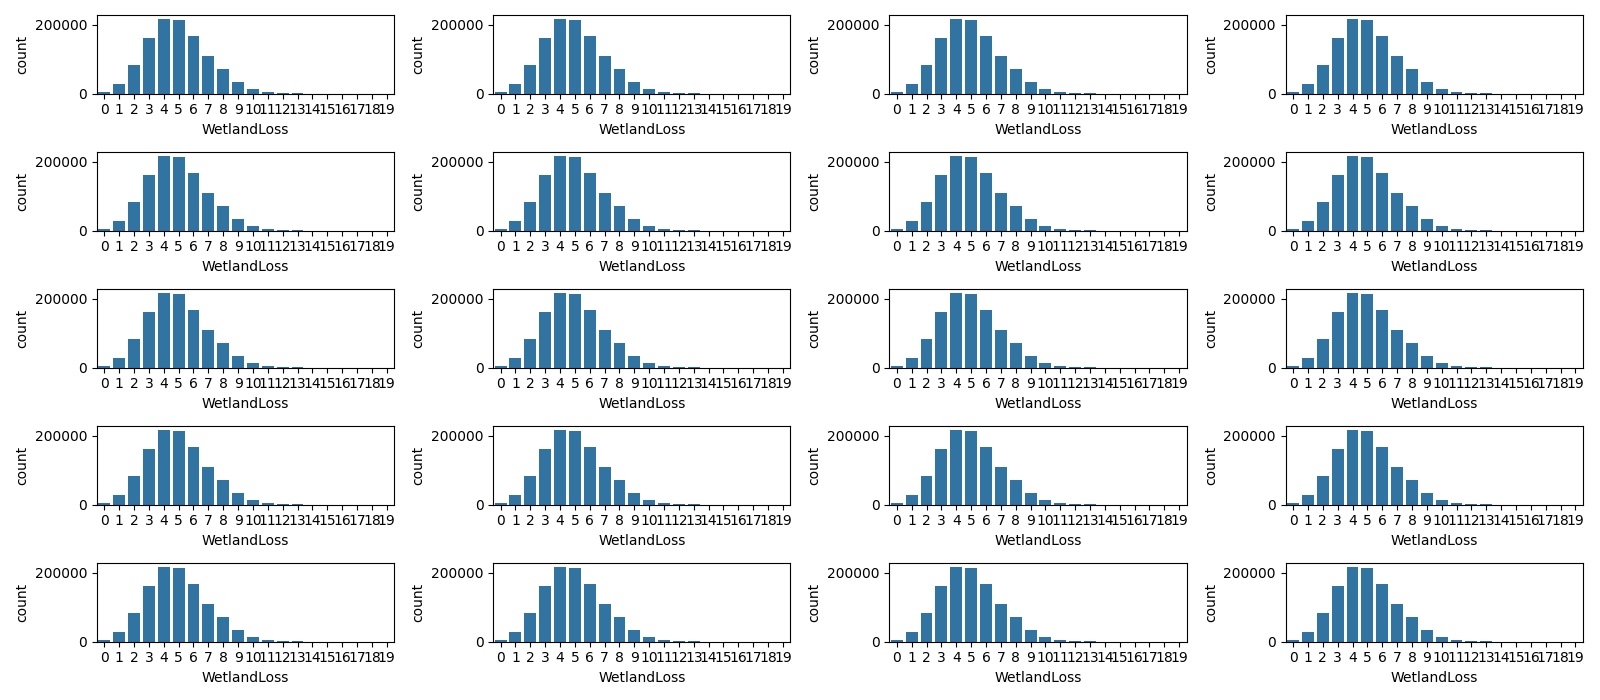

In [9]:
cache_fig(
    'dist_vars', 
    lambda x: [sns.barplot(df_train[i].value_counts(), ax=ax) for ax in x], 
    5, 4, figsize=(16, 7)
)

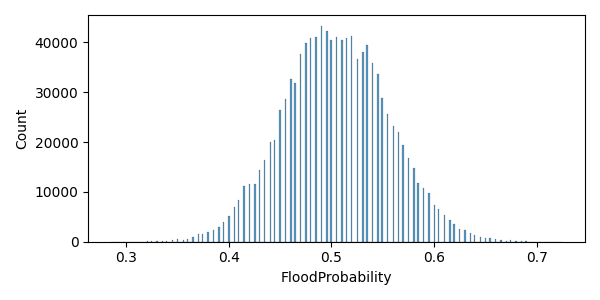

In [10]:
cache_fig(
    'dist_target',
    lambda x: sns.histplot(df_train[target], ax=x),
    1, 1, figsize=(6, 3)
)

In [11]:
df_train[target].value_counts()

FloodProbability
0.490    43320
0.495    42302
0.520    41266
0.485    41156
0.505    41126
         ...  
0.700       32
0.725       29
0.715       26
0.710       23
0.285       20
Name: count, Length: 83, dtype: int64

In [69]:
df_train[target].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
FloodProbability,1117957.0,0.50448,0.051026,0.285,0.47,0.505,0.54,0.725


In [66]:
((df_train[target] * 1000) % 10).value_counts()

FloodProbability
0.0    563257
5.0    554700
Name: count, dtype: int64

In [71]:
from scipy.stats import jarque_bera, kstest, norm

jarque_bera(df_train[target]), kstest(df_train[target], norm.cdf)

(SignificanceResult(statistic=488.6497553253558, pvalue=7.78133010075541e-107),
 KstestResult(statistic=0.6423201749917902, pvalue=0.0, statistic_location=0.385, statistic_sign=-1))

분포상으로 불연속적인 측면이 보입니다.

소수점 세번째 자리수가 0 또는 5입니다.

0.285에서 0.725 사이의 수입니다.

대칭형이여서 혹시 정규분포를 따르는지 확인했지만, 정규분포는 아닙니다.

# Train/Test/Org의 차이를 살펴 봅니다.

In [26]:
from sklearn.model_selection import cross_val_score

def check_diff_train_test():
    df_check = pd.concat([
        df_train[X_all].assign(
            is_train=True
        ),
        df_test[X_all].assign(
            is_train=False
        )
    ], axis=0)
    clf_check = lgb.LGBMClassifier(verbose=-1)
    return cross_val_score(clf_check, df_check[X_all], df_check['is_train'], scoring='roc_auc', cv=5)
result = cache_result('train_test_diff', check_diff_train_test)
np.mean(result)

0.5001223468794278

In [29]:
def check_diff_train_org():
    df_check = pd.concat([
        df_train[X_all].assign(
            is_train=True
        ),
        df_org[X_all].assign(
            is_train=False
        )
    ], axis=0)
    clf_check = lgb.LGBMClassifier(verbose=-1)
    return cross_val_score(clf_check, df_check[X_all], df_check['is_train'], scoring='roc_auc', cv=5)
result = cache_result('train_org_diff', check_diff_train_org)
np.mean(result)

0.6338711250998713

In [30]:
def check_diff_test_org():
    df_check = pd.concat([
        df_test[X_all].assign(
            is_test=True
        ),
        df_org[X_all].assign(
            is_test=False
        )
    ], axis=0)
    clf_check = lgb.LGBMClassifier(verbose=-1)
    return cross_val_score(clf_check, df_check[X_all], df_check['is_test'], scoring='roc_auc', cv=5)
result = cache_result('test_org_diff', check_diff_test_org)
np.mean(result)

0.6340276171500259

Train과 Test는 구분할 수있는 포인트가 없어 보입니다

Org는 Train, Test와 약간의 차이를 보이고 있습니다.
